In [2]:
!pip install tensorflow==2.5.0

     |█████████████████████████████▎  | 415.5 MB 56.2 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 454.3 MB 3.9 kB/s             
     |████████████████████████████████| 462 kB 70.8 MB/s            
     |████████████████████████████████| 1.2 MB 30.9 MB/s            
     |████████████████████████████████| 4.0 MB 30.9 MB/s            
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.46.3
    Uninstalling grpcio-1.46.3:
      Successfully uninstalled grpcio-1.46.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.2
    Uninstalling tensorflow-2.6.2:
      Successfully uninstalled tensorflow-2.6.2


In [33]:
!pip install opencv-python

In [6]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

train_dir = '/local/temp/Project/trainData'
test_dir = '/local/temp/Project/testData'


In [11]:
def image_data(train_dir, test_dir):
    
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      validation_split=0.2,
      subset="training",
      image_size=(256, 256),
      seed=1,
      batch_size=64,
     labels='inferred',
     label_mode='categorical',
     color_mode='rgb',
    )

    val_data = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      validation_split=0.2,
      subset="validation",
      seed=1,
      image_size=(256, 256),
      batch_size=64,
      labels='inferred',
      label_mode='categorical',
      color_mode='rgb',
    )

    test_data = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      seed=1,
      image_size=(256, 256),
      batch_size=64,
      labels='inferred',
      label_mode='categorical',
      color_mode='rgb'
    )
    return train_data, val_data, test_data

In [3]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import glob 

def get_list_of_files(train_dir, test_dir):
    image_files = []
    train_images = glob.glob("{}/*/*.png".format(train_dir))
    test_images = glob.glob("{}/*/*.png".format(test_dir))
    
    return train_images, test_images

def image_to_vector(image: np.ndarray, scale: bool = False) -> np.ndarray:
    length, height, depth = image.shape
    
    if scale:
        image.reshape((1, length * height * depth))/255.0
        
    return image.reshape((1, length * height * depth))

def read_data(image_files, scale: bool = False):
    image_array = []
    labels = []
    for image_file in image_files:
        im = cv2.imread(image_file)
        im = image_to_vector(im, scale)
        image_array.append(im)
        labels.append(image_file.split('/')[-2])

    image_array = np.vstack(image_array)
    return image_array, labels


In [79]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten


def train_dnn(train_data, test_data, y_train, y_test):
    n_features = train_data.shape[1]

    model = Sequential()
    model.add(Dense(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    # model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(train_data, y_train, epochs=15, batch_size=64, verbose=1, 
                        validation_split=0.3, 
                        # callbacks=[es]
                       )

    model.summary()

    loss, acc = model.evaluate(test_data, y_test, verbose=1)
    print('Test Accuracy: %.3f' % acc)

    # plot learning curves
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Cross Entropy')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()
    
    return model


def train_cnn(train_data, val_data, test_data, n_classes=5):    
    # define model
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2, 2)))    
    
    model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2, 2)))    
    model.add(Flatten()) 
    
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    # model.add(Dropout(0.25))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    # define loss and optimizer
    #sparse_categorical_crossentropy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # fit the model
    history = model.fit(train_data, epochs=10, validation_data=val_data, shuffle=True)
    model.summary()    
        
    # evaluate the model
    loss, acc = model.evaluate(test_data, verbose=1)
    print('Accuracy: %.3f' % acc)    
    
    # plot learning curves
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Cross Entropy')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()
    
    return model


### Train CNN

In [77]:
train_img_data, val_img_data, test_img_data = image_data(train_dir, test_dir)

Found 2205 files belonging to 5 classes.
Using 1764 files for training.
Found 2205 files belonging to 5 classes.
Using 441 files for validation.
Found 545 files belonging to 5 classes.


Epoch 1/10
28/28 [==============================] - 106s 4s/step - loss: 6345.1187 - accuracy: 0.4059 - val_loss: 53.1288 - val_accuracy: 0.5329
Epoch 2/10
28/28 [==============================] - 104s 4s/step - loss: 28.4320 - accuracy: 0.5493 - val_loss: 7.2121 - val_accuracy: 0.5624
Epoch 3/10
28/28 [==============================] - 103s 4s/step - loss: 3.3122 - accuracy: 0.6117 - val_loss: 1.6084 - val_accuracy: 0.5760
Epoch 4/10
28/28 [==============================] - 104s 4s/step - loss: 1.2157 - accuracy: 0.6536 - val_loss: 1.1591 - val_accuracy: 0.5714
Epoch 5/10
28/28 [==============================] - 104s 4s/step - loss: 0.9576 - accuracy: 0.6752 - val_loss: 1.0921 - val_accuracy: 0.6168
Epoch 6/10
28/28 [==============================] - 103s 4s/step - loss: 0.8042 - accuracy: 0.7069 - val_loss: 1.0762 - val_accuracy: 0.6327
Epoch 7/10
28/28 [==============================] - 104s 4s/step - loss: 0.7082 - accuracy: 0.7387 - val_loss: 1.0274 - val_accuracy: 0.6440
Epoch 8/

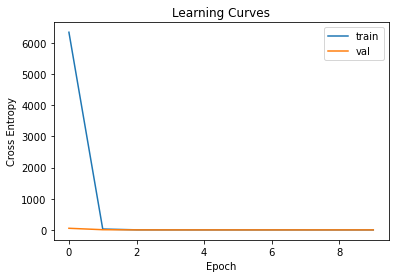

In [80]:
# cnn_model = train_cnn(train_img_data, val_img_data, test_img_data)
cnn_model = train_cnn(train_img_data, val_img_data, test_img_data)


In [83]:
test_img_data.class_names

['healthy', 'mild', 'moderate', 'proliferate', 'severe']

In [85]:
def predict_cnn(test_img_data):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    for image_batch, label_batch in test_img_data:   # use dataset.unbatch() with repeat
       # append true labels
       y_true.append(label_batch)
       # compute predictions
       preds = cnn_model.predict(image_batch)
       # append predicted labels
       y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)        
    
    print(classification_report(np.argmax(correct_labels.numpy(), axis=1), 
                                predicted_labels.numpy(), 
                                target_names=test_img_data.class_names))
    return predicted_categories, y_pred, test_labels

In [86]:
predict_cnn(val_img_data)
predict_cnn(test_img_data)

              precision    recall  f1-score   support

     healthy       0.86      0.90      0.88       156
        mild       0.35      0.47      0.40        55
    moderate       0.61      0.71      0.65       150
 proliferate       0.18      0.11      0.13        38
      severe       0.71      0.12      0.20        42

    accuracy                           0.64       441
   macro avg       0.54      0.46      0.45       441
weighted avg       0.64      0.64      0.61       441

              precision    recall  f1-score   support

     healthy       0.86      0.89      0.88       200
        mild       0.41      0.57      0.47        74
    moderate       0.61      0.71      0.66       180
 proliferate       0.32      0.13      0.19        53
      severe       0.00      0.00      0.00        38

    accuracy                           0.65       545
   macro avg       0.44      0.46      0.44       545
weighted avg       0.61      0.65      0.62       545



(array([2, 2, 0, 1, 0, 1, 2, 0, 2, 2, 3, 2, 0, 0, 3, 2, 2, 2, 2, 1, 2, 0,
        0, 0, 1, 2, 1, 2, 0, 1, 0, 1, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 1, 0,
        0, 0, 2, 0, 0, 1, 2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 3, 2,
        2, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 1, 2, 0, 1, 1, 2, 1, 1, 0, 2, 1,
        1, 2, 1, 2, 0, 1, 0, 2, 2, 1, 4, 2, 0, 1, 2, 0, 2, 1, 1, 0, 2, 2,
        0, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 3, 2, 0, 2, 1, 2, 0, 0, 3, 2, 3,
        1, 0, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2,
        2, 2, 0, 3, 2, 3, 2, 3, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 2, 3, 1,
        0, 1, 1, 0, 1, 0, 1, 2, 2, 1, 2, 0, 2, 1, 3, 0, 0, 2, 0, 1, 1, 2,
        2, 0, 3, 1, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2, 3, 0, 2, 0, 2, 2, 0, 0,
        2, 0, 1, 2, 0, 2, 2, 0, 2, 1, 2, 0, 0, 0, 4, 0, 2, 2, 2, 2, 0, 2,
        1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 3, 0, 1, 1, 1, 2, 0, 0, 2, 1,
        1, 2, 2, 2, 1, 1, 1, 2, 0, 0, 0, 1, 2, 0, 2, 3, 1, 0, 0, 0, 2, 1,
        0, 1, 0, 0, 3, 1, 1, 1, 1, 0, 

array([3, 0, 0, 3, 2, 3, 2, 0, 3, 0, 1, 0, 2, 1, 2, 2, 0, 0, 0, 0, 1, 0,
       3, 3, 2, 1, 0, 1, 0, 2, 2, 2, 0, 2, 2, 0, 2, 4, 4, 3, 4, 2, 0, 0,
       2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 3, 0, 1, 2, 2, 0, 2, 0, 3, 1, 4,
       4, 3, 2, 1, 1, 0, 2, 0, 3, 0, 4, 2, 2, 2, 2, 3, 0, 0, 2, 1, 0, 2,
       1, 0, 2, 0, 2, 0, 0, 0, 2, 3, 2, 2, 2, 2, 0, 4, 2, 0, 1, 0, 4, 3,
       1, 4, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 4, 3, 2, 2, 2, 1, 0, 1, 2,
       2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 0, 2, 2, 1, 4, 0, 0, 2, 4,
       4, 0, 1, 3, 3, 0, 2, 4, 1, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0,
       2, 1, 0, 0, 2, 4, 2, 0, 3, 2, 0, 0, 0, 2, 2, 0, 3, 1, 2, 2, 3, 2,
       4, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 4, 0, 2,
       0, 1, 1, 0, 0, 1, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 0, 0, 0,
       1, 1, 0, 2, 1, 0, 2, 2, 3, 0, 3, 2, 0, 2, 4, 2, 2, 2, 1, 1, 0, 1,
       0, 0, 0, 3, 4, 1, 2, 3, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 3,
       0, 4, 3, 4, 1, 3, 2, 3, 0, 0, 0, 2, 1, 0, 1,

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       200
           1       0.40      0.66      0.50        74
           2       0.55      0.67      0.60       180
           3       0.33      0.13      0.19        53
           4       0.00      0.00      0.00        38

    accuracy                           0.63       545
   macro avg       0.44      0.46      0.43       545
weighted avg       0.61      0.63      0.61       545



In [47]:
# predict_cnn(val_img_data)
predicted_categories, y_pred, test_labels = predict_cnn(val_img_data)
predicted_categories, y_pred, test_labels = predict_cnn(test_img_data)

Classification Report
              precision    recall  f1-score   support

     healthy       0.35      0.32      0.34       156
        mild       0.14      0.25      0.18        55
    moderate       0.32      0.37      0.34       150
 proliferate       0.14      0.08      0.10        38
      severe       0.00      0.00      0.00        42

    accuracy                           0.28       441
   macro avg       0.19      0.20      0.19       441
weighted avg       0.26      0.28      0.27       441

Classification Report
              precision    recall  f1-score   support

     healthy       0.36      0.32      0.34       200
        mild       0.09      0.15      0.11        74
    moderate       0.33      0.41      0.37       180
 proliferate       0.14      0.06      0.08        53
      severe       0.25      0.03      0.05        38

    accuracy                           0.28       545
   macro avg       0.24      0.19      0.19       545
weighted avg       0.29      0.28

### Train DNN

In [ ]:
im = cv2.imread(train_files[0])
im_reshaped = image_to_vector(im)
pyplot.imshow(im, cmap=pyplot.get_cmap('gray'))


Epoch 1/15
25/25 [==============================] - 5s 189ms/step - loss: 9981.4014 - accuracy: 0.2903 - val_loss: 6276.3652 - val_accuracy: 0.4924
Epoch 2/15
25/25 [==============================] - 4s 181ms/step - loss: 4015.8076 - accuracy: 0.3545 - val_loss: 1968.4730 - val_accuracy: 0.3625
Epoch 3/15
25/25 [==============================] - 4s 178ms/step - loss: 1748.3214 - accuracy: 0.4582 - val_loss: 598.0143 - val_accuracy: 0.4804
Epoch 4/15
25/25 [==============================] - 4s 177ms/step - loss: 1363.5499 - accuracy: 0.4588 - val_loss: 1519.1957 - val_accuracy: 0.4502
Epoch 5/15
25/25 [==============================] - 4s 177ms/step - loss: 1217.4628 - accuracy: 0.4485 - val_loss: 1731.7893 - val_accuracy: 0.4517
Epoch 6/15
25/25 [==============================] - 4s 180ms/step - loss: 1426.3635 - accuracy: 0.4951 - val_loss: 1143.5277 - val_accuracy: 0.3233
Epoch 7/15
25/25 [==============================] - 4s 180ms/step - loss: 630.6315 - accuracy: 0.5301 - val_loss:

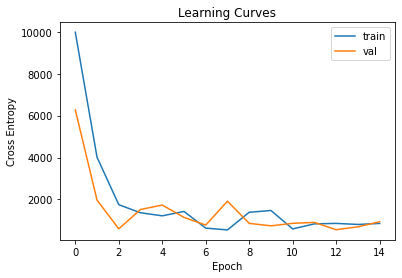

In [21]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical


train_files, test_files = get_list_of_files(train_dir, test_dir)

# Shuffle before calling Train
np.random.shuffle(train_files)
train_data, train_labels = read_data(train_files, scale=True)

test_data, test_labels = read_data(test_files)

enc = LabelEncoder().fit(train_labels)
y_train = enc.transform(train_labels)
y_train = to_categorical(y_train)

y_test = enc.transform(test_labels)
y_test = to_categorical(y_test)


dnn_model = train_dnn(train_data, test_data, y_train, y_test)

In [22]:
y_predicted = dnn_model.predict(test_data)
y_predicted = np.argmax(y_predicted, axis=-1)

y_test = enc.transform(test_labels)
y_test = to_categorical(y_test)

y_test = np.argmax(y_test, axis=-1)
print(classification_report(y_test, y_predicted, digits=4))

              precision    recall  f1-score   support

           0     0.9371    0.8200    0.8747       200
           1     0.0000    0.0000    0.0000        74
           2     0.4757    0.9778    0.6400       180
           3     0.0000    0.0000    0.0000        53
           4     0.0000    0.0000    0.0000        38

    accuracy                         0.6239       545
   macro avg     0.2826    0.3596    0.3029       545
weighted avg     0.5010    0.6239    0.5324       545



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,